In [1]:
from data_loader import DataGenerator
from datetime import datetime
from model import model_builder
from tensorflow.keras.callbacks import (EarlyStopping, ReduceLROnPlateau,
                                        ModelCheckpoint, TensorBoard)
from tensorflow.keras.models import load_model
from tensorflow.keras.backend import clear_session
import numpy as np
import warnings
from config import (model_config, data_generator_config, load_from_file,
                    n_epochs, model_name, tb_logs_path, model_checkpoint_file, test_seq_path)
from tensorflow.keras.losses import MSE, MAE
from tqdm import tqdm
from sklearn.metrics import precision_recall_fscore_support as prf_score
from sklearn.metrics import accuracy_score
from matplotlib import pyplot as plt
from tqdm import tqdm
np.set_printoptions(suppress=True)
n_batches = 320

In [49]:
def get_err_of_model(model, X, err_f, shape):
    preds = model.predict(X)
    errs = err_f(X.reshape(shape), preds.reshape(shape))
    err_of_mods = []
    for i, m_ix in enumerate(modifs_idx):
        if m_ix.shape[0] > 3 and m_ix.shape[0] < 50:
            err_of_mods.append(err_f(X[i, m_ix].flatten(),
                                     preds[i, m_ix].flatten()))
    overall_err_med = np.median(errs)
    overall_err_mean = np.mean(errs)
    mods_err_med = np.median(err_of_mods)
    mods_err_mean = np.mean(err_of_mods)
    return {"err (med, mean)": (overall_err_med, overall_err_mean), 
            "modifications_err (med, mean)": (mods_err_med, mods_err_mean)}

def rolling_window(a, window):
    shape = a.shape[:-1] + (a.shape[-1] - window + 1, window)
    strides = a.strides + (a.strides[-1],)
    return np.lib.stride_tricks.as_strided(a, shape=shape, strides=strides)

# def get_roll_mses(signal, pred):
#     roll_mses = []
#     for idx in rolling_window(np.arange(signal.shape[0]), 25):
#         roll_mses.append(np.median(MSE(signal[idx], pred[idx])))
#     return np.array(roll_mses)

def get_roll_mses(mse):
    roll_mses = []
    for idx in rolling_window(np.arange(mse.shape[0]), 12):
        roll_mses.append(np.median(mse))
    return np.array(roll_mses)

# def get_y_from_rolling(X, preds, modifs_idx, threshold):
#     y_true = []
#     y_pred = []
#     for sample, pred, mod_ix in tqdm(zip(X, preds, modifs_idx)):
#         mses = get_roll_mses(sample, pred)
#         if np.where(mses > threshold):
#             y_pred.append(1)
#         else:
#             y_pred.append(0)
#         if mod_ix.shape[0] > 1:
#             y_true.append(1)
#         else:
#             y_true.append(0)
#     return y_true, y_pred

In [3]:
data_generator_config['quality_threshold'] = 20.5
data_generator_config['test'] = True
data_generator_config['seq_path'] = test_seq_path
data_generator_config['load2ram'] = False
data_generator_config['step_len'] = 64
# data_generator_config['motifs'] = ["CCAGG", "CCTGG", "GATC"]
data_generator_config

{'sample_len': 512,
 'batch_size': 1000,
 'quality_threshold': 20.5,
 'normalize': 'MEDIAN',
 'random_sample': True,
 'step_len': 64,
 'load2ram': False,
 'test': True,
 'seq_path': '/tf/puc19/nanopore/MAP_Data/08_07_16_R9_pUC_BC/MA/downloads/pass/NB08/*.fast5'}

In [4]:
data_loader = DataGenerator(**data_generator_config)

/tf/puc19/nanopore/MAP_Data/08_07_16_R9_pUC_BC/MA/downloads/pass/NB08/*.fast5


In [5]:
X = []
modifs_idx = []
modifs_type = []
for _ in tqdm(range(n_batches)):
    x, m_idx, type_ = next(data_loader)
    X.append(x)
    modifs_idx.append(m_idx)
    modifs_type.append(type_)

 13%|█▎        | 43/320 [01:05<04:36,  1.00it/s]

unable to open file /tf/puc19/nanopore/MAP_Data/08_07_16_R9_pUC_BC/MA/downloads/pass/NB08/makeson_PC_20160809_FNFAD20242_MN17284_sequencing_run_MA_470_R9_pUC_g_PCR_BC_2_08_07_16_80510_ch180_read404_strand.fast5


 89%|████████▉ | 285/320 [07:24<00:33,  1.06it/s]

unable to open file /tf/puc19/nanopore/MAP_Data/08_07_16_R9_pUC_BC/MA/downloads/pass/NB08/makeson_PC_20160807_FNFAD20242_MN17284_sequencing_run_MA_470_R9_pUC_g_PCR_BC_08_07_16_93165_ch432_read1037_strand.fast5


100%|██████████| 320/320 [08:15<00:00,  1.55s/it]


In [14]:
X = np.array(X).reshape(n_batches*data_loader.batch_size, 
                        data_loader.sample_len, 1)
shape_ = (n_batches*data_loader.batch_size, data_loader.sample_len)
modifs_idx = np.array(modifs_idx).reshape(shape_[0])
modifs_idx = modifs_idx.flatten()

In [17]:
from tensorflow.keras import layers
clear_session()
model64 = load_model(r"1612/4_layers_CNN_mse.h5", custom_objects={'ELU': layers.ELU})
print("MSE: ", get_err_of_model(model64, X, MSE, shape_))
print("MAE: ", get_err_of_model(model64, X, MAE, shape_))

MSE:  {'err (med, mean)': (0.026580337, 0.027800487), 'modifications_err (med, mean)': (0.073230974, 0.089759864)}
MAE:  {'err (med, mean)': (0.11655973, 0.11715461), 'modifications_err (med, mean)': (0.20279285, 0.21518749)}


In [18]:
from tensorflow.keras import layers
clear_session()
model32 = load_model(r"1312/4_layers_CNN_mse.h5", custom_objects={'ELU': layers.ELU})
print("MSE: ", get_err_of_model(model32, X, MSE, shape_))
print("MAE: ", get_err_of_model(model32, X, MAE, shape_))

MSE:  {'err (med, mean)': (0.0546649, 0.056675885), 'modifications_err (med, mean)': (0.12493844, 0.15795715)}
MAE:  {'err (med, mean)': (0.17461228, 0.17549528), 'modifications_err (med, mean)': (0.28954852, 0.30992076)}


In [19]:
data_generator_config['quality_threshold'] = 14
data_generator_config['test'] = False

In [93]:
preds32 = model32.predict(X)
preds64 = model64.predict(X)
X_shaped = X.reshape(shape_)
preds_shaped = preds32.reshape(shape_)
preds_shaped = preds64.reshape(shape_)

In [94]:
with_modif = np.array([i for i, ix in enumerate(modifs_idx) if 3 < len(ix) < 50])
without_modif = np.array([i for i, ix in enumerate(modifs_idx) if not len(ix)])
print(with_modif.shape)
print(without_modif.shape)

(81792,)
(235494,)


In [95]:
without_modif = without_modif[::2]

In [96]:
X_cropped = X[:, 100:-100]
preds_cropped32 = preds32[:, 100:-100]
preds_cropped64 = preds64[:, 100:-100]

In [97]:
modif_ix = []
with_modif_in_middle = []
for ix in with_modif:
    if modifs_idx[ix][0] > 200 and modifs_idx[ix][-1] < 312:
        modif_ix.append(modifs_idx[ix] - 100)
        with_modif_in_middle.append(ix)
with_modif_in_middle = np.array(with_modif_in_middle)

In [98]:
mses32 = np.array([np.array(MSE(x, y)) 
                   for x, y in tqdm(zip(X_cropped, preds_cropped32))])
mses64 = np.array([np.array(MSE(x, y)) 
                   for x, y in tqdm(zip(X_cropped, preds_cropped64))])

320000it [03:09, 1686.15it/s]
320000it [03:11, 1668.94it/s]


In [99]:
without_modif_set = set(without_modif)
with_modif_in_middle_set = set(with_modif_in_middle)
if len(without_modif_set.intersection(set(with_modif_in_middle))):
    raise ValueError("hmm")

In [ ]:
median_rolled_mses_without32 = []
median_rolled_mses_with32 = []
avg_mse_without32 = []
avg_mse_with32 = []

median_rolled_mses_without64 = []
median_rolled_mses_with64 = []
avg_mse_without64 = []
avg_mse_with64 = []

for idx in tqdm(range(len(mses))):
    if idx not in without_modif_set and idx not in with_modif_in_middle_set:
        continue
    if idx in without_modif_set:
        median_rolled_mses_without32.append(get_roll_mses(mses32[idx]))
        median_rolled_mses_without64.append(get_roll_mses(mses64[idx]))
        avg_mse_without32.append(mses32[idx].mean())
        avg_mse_without64.append(mses64[idx].mean())
    if idx in with_modif_in_middle_set:
        median_rolled_mses_with32.append(get_roll_mses(mses32[idx]))
        median_rolled_mses_with64.append(get_roll_mses(mses64[idx]))
        avg_mse_with32.append(mses32[idx].mean())
        avg_mse_with64.append(mses64[idx].mean())

  5%|▌         | 17061/320000 [09:28<3:21:30, 25.06it/s]

In [51]:
# now = datetime.now()
# avg_mse_without = mses[list(without_modif)].mean(1)
# avg_mse_with = mses[list(with_modif_in_middle)].mean(1)
# median_rolled_mses_without = np.apply_along_axis(get_roll_mses, 1, mses[list(without_modif)])
# median_rolled_mses_with = np.apply_along_axis(get_roll_mses, 1, mses[list(with_modif_in_middle)])
# print(datetime.now() - now)

2:44:04.370926


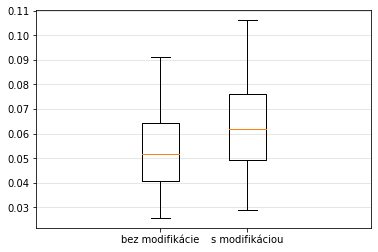

In [92]:
p_min_without = np.percentile(avg_mse_without, 5)
p_max_without = np.percentile(avg_mse_without, 95)
p_min_with = np.percentile(avg_mse_with, 5)
p_max_with = np.percentile(avg_mse_with, 95)
without_ = avg_mse_without[(avg_mse_without > p_min_without) & (avg_mse_without < p_max_without)]
with_ = avg_mse_with[(avg_mse_with > p_min_with) & (avg_mse_with < p_max_with)]
plt.boxplot([without_, with_], labels=['bez modifikácie', 's modifikáciou'], positions=[0.45, 0.8])
plt.grid(axis='y', color='#dee3df')
plt.show()

In [ ]:
# preds = model1.predict(X)
from matplotlib import pyplot as plt
x = np.arange(X[29].flatten().shape[0])
plt.plot(x, X[29].flatten(), label="vstup")
plt.plot(x, preds[29].flatten(), label="výstup")
plt.legend()
plt.show()